In [143]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [204]:
#trainset_01 = datasets.MNIST('/Users/Amartya/data', train=True, download=True,
                   #transform = np.asarray)
trainset_01 = datasets.MNIST('/Users/Amartya/data', train=True, download=True,
                   transform = transforms.ToTensor())
idx = trainset_01.targets <= 1
trainset_01.targets = trainset_01.targets[idx]
trainset_01.data = trainset_01.data[idx]
train_loader01 = torch.utils.data.DataLoader(trainset_01,
    batch_size=64, shuffle=True)

def view_samples(samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [205]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")



GPU not available, CPU used


In [208]:
class Generator1(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator1, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out
    
class Discriminator1(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator1, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        #x = x.float()
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out



In [209]:
# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

In [210]:
# instantiate discriminator and generator
D = Discriminator1(input_size, d_hidden_size, d_output_size)
#D = Discriminator()
G = Generator1(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print(G)

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

Discriminator1(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator1(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [211]:
# training hyperparams
num_epochs = 15

# keep track of loss and generated, "fake" samples
#samples = []
#losses = []

print_every = 50

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader01):
                
        real_images = real_images.to(device)
        
        batch_size = real_images.size(0)
        
        #real_images = real_images.view(-1, 28, 28)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = torch.empty([64, z_size]).uniform_(-1,1)
        #z = torch.empty([64, 28, z_size]).uniform_(-1,1)
        fake_images = G(z)
        fake_images = fake_images.to(device)
        #fake_images = fake_images.view(-1,28,28)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = torch.empty([64, z_size]).uniform_(-1,1)
        #z = torch.empty([64, 28, z_size]).uniform_(-1,1)
        fake_images = G(z)
        fake_images = fake_images.to(device)
        #fake_images = fake_images.view(-1,28,28)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

Epoch [    1/   15] | d_loss: 1.3860 | g_loss: 0.6861
Epoch [    1/   15] | d_loss: 1.1408 | g_loss: 0.7979
Epoch [    1/   15] | d_loss: 0.7052 | g_loss: 2.0347
Epoch [    1/   15] | d_loss: 0.5902 | g_loss: 3.7241
Epoch [    2/   15] | d_loss: 0.6417 | g_loss: 10.2345
Epoch [    2/   15] | d_loss: 0.6433 | g_loss: 5.0127
Epoch [    2/   15] | d_loss: 1.0861 | g_loss: 4.0729
Epoch [    2/   15] | d_loss: 0.9593 | g_loss: 3.1550
Epoch [    3/   15] | d_loss: 1.5353 | g_loss: 0.9994
Epoch [    3/   15] | d_loss: 1.0126 | g_loss: 2.5630
Epoch [    3/   15] | d_loss: 0.6427 | g_loss: 5.0180
Epoch [    3/   15] | d_loss: 0.5664 | g_loss: 4.9727
Epoch [    4/   15] | d_loss: 0.8786 | g_loss: 4.8032
Epoch [    4/   15] | d_loss: 0.8081 | g_loss: 4.8679
Epoch [    4/   15] | d_loss: 1.1786 | g_loss: 1.5674
Epoch [    4/   15] | d_loss: 1.1268 | g_loss: 0.9854
Epoch [    5/   15] | d_loss: 0.9389 | g_loss: 1.1565
Epoch [    5/   15] | d_loss: 0.7146 | g_loss: 1.9021
Epoch [    5/   15] | d_los

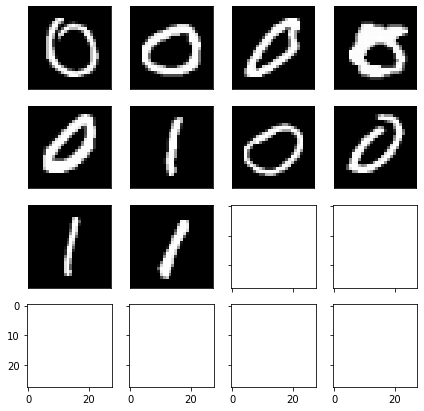

In [188]:
z = torch.empty([12665, z_size]).uniform_(-1,1)
G.eval()
samples=G(z)
samples = (samples + 1)* 0.5
view_samples(x[10:20])

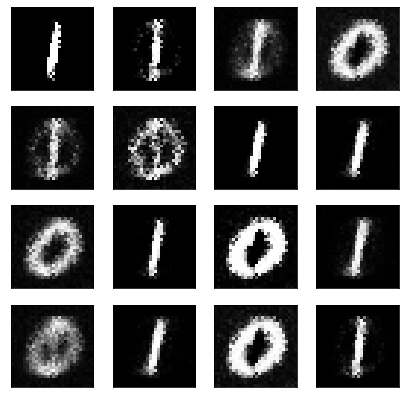

In [214]:
z = torch.empty([12665, z_size]).uniform_(-1,1)
G.eval()
samples=G(z)
samples = (samples + 1)* 0.5
samples = samples* 255
view_samples(samples[70:90])

In [228]:
trainset_01.data.size()

torch.Size([12665, 28, 28])